In [2]:
!git clone https://github.com/KORALLLL/diffusion.git
!pip install torcheval

fatal: destination path 'diffusion' already exists and is not an empty directory.


In [3]:
import pickle, gzip, math, os,sys, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc, random
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

from fastcore.test import test_close
import logging



sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('/kaggle/working/diffusion'))


from diffusion.data_utils import *
from diffusion.learners import *
from diffusion.callbacks import *
from diffusion.metrics import *
from diffusion.utils import *
from diffusion.modules import *

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

logging.disable(logging.WARNING)

set_seed(42)

In [20]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)
xmean, xstd = 0.28, 0.35

@inplace
def transformi(b): b[x] = [(TF.to_tensor(o)-xmean) / xstd for o in b[x]]
    
bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [6]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [7]:
set_seed(42)
lr, epochs = 6e-2, 5

# going wider

In [8]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256, 512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1,16, ks=5,stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs) - 1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.783,0.820,0,True
0.862,0.430,0,False
0.885,0.416,1,True
0.871,0.399,1,False
0.912,0.294,2,True
0.904,0.310,2,False
0.936,0.215,3,True
0.922,0.267,3,False
0.958,0.152,4,True
0.928,0.236,4,False


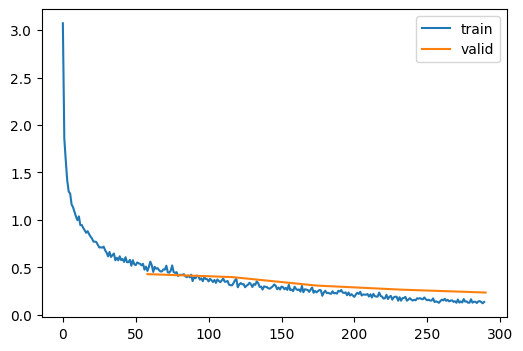

In [12]:
learn.fit(epochs)

# Pooling

In [10]:
class GlobalAvgPool(nn.Module):
    def forward(self, x): return x.mean((-2,-1))

In [11]:
def get_model2(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1,16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to('cuda:0')

In [12]:
#|export
def _flops(x, h, w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w

@fc.patch
def summary(self:TrainLearner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp,totf = 0,0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparms = sum(o.numel() for o in mod.parameters())
        totp += nparms
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|{flops:.1f}|\n'
    try:
        with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
    except:
        pass
    print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [16]:
TrainLearner(get_model2(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()


Tot params: 4900532; MFLOPS: 33.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6816|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14336|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57344|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229376|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|917504|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3670016|14.7|
|GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5120|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.792,0.798,0,True
0.867,0.463,0,False
0.883,0.426,1,True
0.887,0.344,1,False
0.913,0.290,2,True
0.907,0.292,2,False
0.936,0.214,3,True
0.921,0.261,3,False


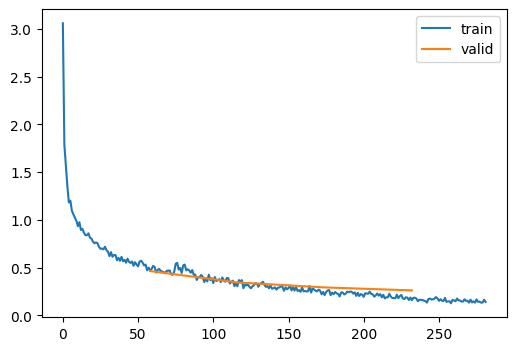

In [ ]:
set_seed(42)
model = get_model2(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [13]:
def get_model3(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1,16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256,10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to('cuda:0')

In [18]:
TrainLearner(get_model3(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1227956; MFLOPS: 18.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6816|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14336|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57344|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229376|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|917504|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


In [19]:
[o.shape for o in get_model3()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16, 16, 5, 5]),
 torch.Size([16, 1, 1, 1])]

accuracy,loss,epoch,train
0.778,0.844,0,True
0.860,0.499,0,False
0.891,0.407,1,True
0.886,0.344,1,False
0.915,0.287,2,True
0.912,0.282,2,False
0.938,0.211,3,True
0.925,0.252,3,False
0.959,0.153,4,True
0.928,0.233,4,False


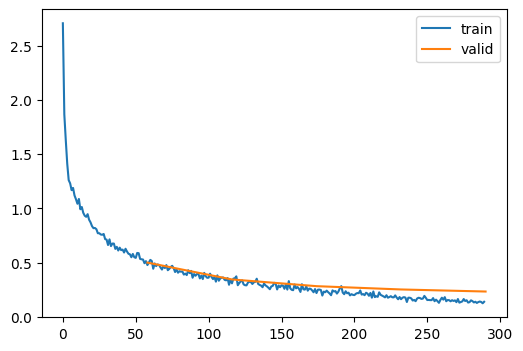

In [20]:
set_seed(42)
model = get_model3(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [14]:
def get_model4(act=nn.ReLU, nfs=(16,32,64, 128,256), norm=nn.BatchNorm2d):
    layers = [conv(1,16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256,10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to('cuda:0')

In [24]:
[o.shape for o in get_model4()[0].parameters()]

[torch.Size([16, 1, 5, 5]), torch.Size([16]), torch.Size([16])]

In [25]:
TrainLearner(get_model4(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1221572; MFLOPS: 13.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 16, 28, 28)|432|0.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14336|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57344|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229376|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|917504|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.791,0.812,0,True
0.873,0.469,0,False
0.890,0.408,1,True
0.890,0.341,1,False
0.915,0.287,2,True
0.908,0.283,2,False
0.936,0.214,3,True
0.918,0.270,3,False
0.959,0.155,4,True
0.923,0.246,4,False


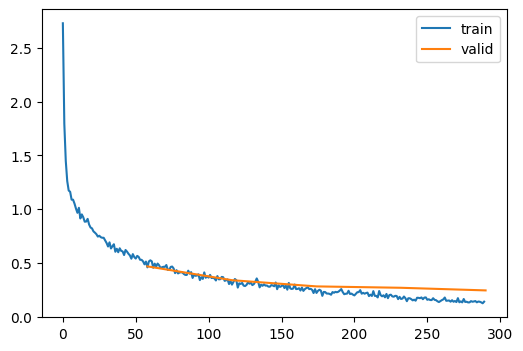

In [27]:
set_seed(42)
model = get_model4(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

# Data augmentation

In [15]:
from torchvision import transforms

In [16]:
# export

class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()
        
    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [17]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop): return tfm_x(b[0]), tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                    transforms.RandomHorizontalFlip())

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])

In [40]:
learn.fit(1)

CancelFitException: 

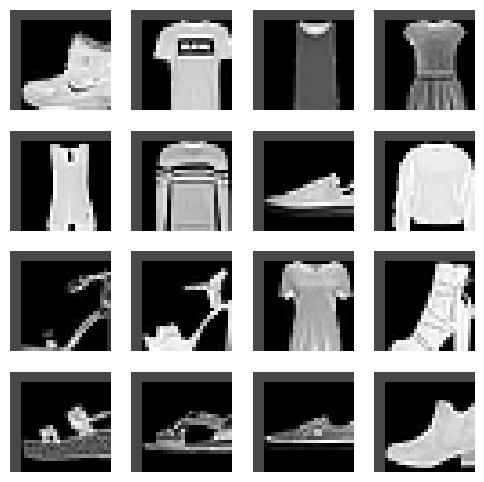

In [45]:
xb, yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [46]:
learn.fit(1)

CancelFitException: 

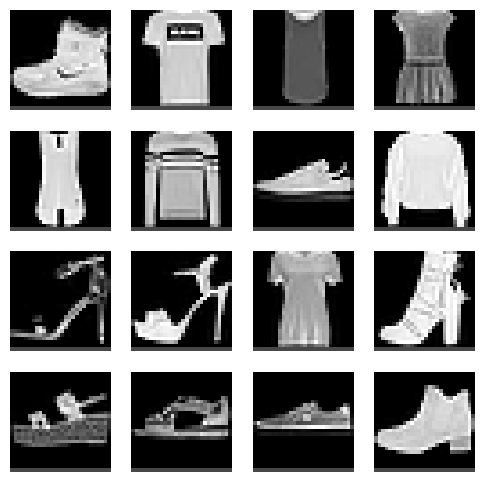

In [48]:
xb, yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [51]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                    transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [18]:
bs

512

In [21]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy.copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k: f'{v.compute():.3f}' for k, v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = learn.model.training
        self._log(log)

    def after_batch(self, learn):
        x, y, *_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss.item()), weight=len(x))

In [33]:
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

In [32]:
for h in astats:
    print(h)

In [28]:
sys.getsizeof(astats)

48

accuracy,loss,epoch,train
0.646,1.198,0,True
0.733,0.849,0,False
0.765,0.815,1,True
0.766,0.686,1,False
0.791,0.703,2,True
0.719,0.818,2,False
0.796,0.649,3,True
0.791,0.623,3,False
0.813,0.568,4,True
0.778,0.685,4,False


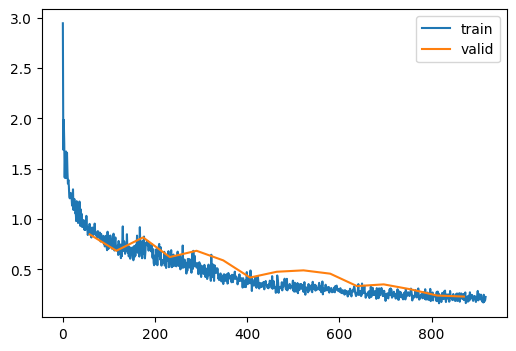

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7ece0772e950>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/matplotlib/transforms.py", line 209, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


KeyboardInterrupt: 

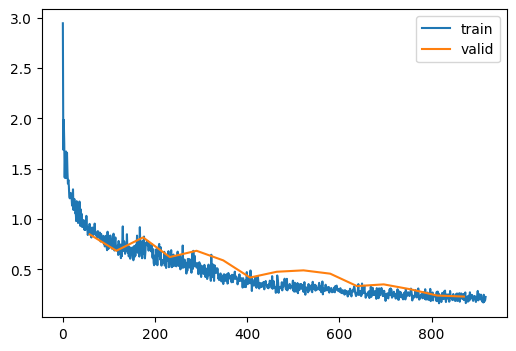

In [34]:
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)
torch.save(learn.model, mdl_path/'data_aug.pkl')

# TTA

In [38]:
class CapturePredsCB(Callback):
    def before_fit(self, learn): self.all_preds, self.all_targs = [], []
    def after_batch(self, learn):
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

accuracy,loss,epoch,train
0.911,0.254,0,False


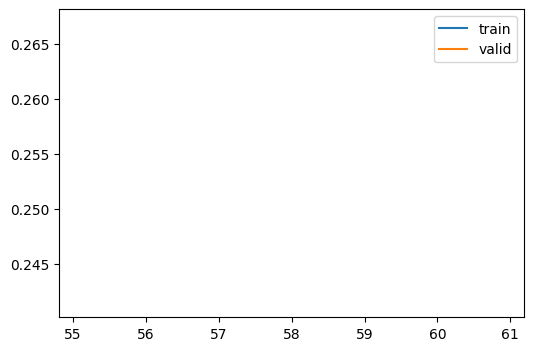

In [39]:
cp = CapturePredsCB()
learn.fit(1, train=False, cbs=cp)

accuracy,loss,epoch,train
0.908,0.253,0,False


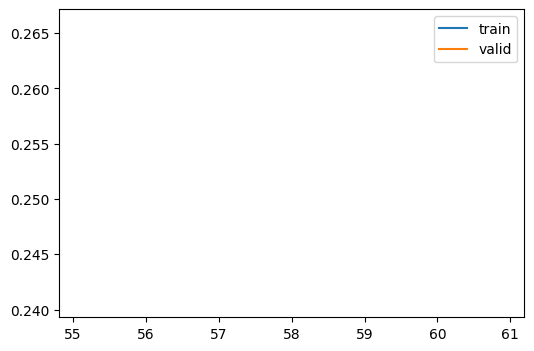

In [41]:
cp2 = CapturePredsCB()
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
learn.fit(1, train=False, cbs=[cp2, ttacb])

In [42]:
ap1 = torch.cat(cp.all_preds)
ap2 = torch.cat(cp2.all_preds)
at = torch.cat(cp.all_targs)
ap1.shape, ap2.shape

(torch.Size([9216, 10]), torch.Size([9216, 10]))

In [43]:
ap = torch.stack([ap1, ap2]).mean(0).argmax(1)

In [44]:
round((ap==at).float().mean().item(), 3)

0.913

# Random erase

In [45]:
xb, _ = next(iter(dls.train))
xbt = xb[:16]

In [46]:
xm, xs = xbt.mean(), xbt.std()

In [47]:
xbt.min(), xbt.max()

(tensor(-0.80), tensor(2.06))

In [48]:
pct = 0.2

In [49]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx = int(random.random()*(1-pct)*xbt.shape[-2])
sty = int(random.random()*(1-pct)*xbt.shape[-1])
stx, sty, szx, szy

(14, 0, 5, 5)

In [56]:
init.normal_(xbt[:, :, stx:stx+szx, sty:sty+szy], mean=xm, std=xs)

tensor([[[[     1.64,      0.94,      0.32,      1.27,      0.53],
          [    -0.94,      1.73,      0.21,     -1.05,      0.19],
          [     0.50,      0.49,      1.69,      1.17,     -0.68],
          [     0.05,     -1.75,     -0.24,      1.28,     -1.55],
          [    -0.84,     -1.40,      1.17,     -0.62,     -0.64]]],


        [[[    -0.98,      0.05,     -0.46,      0.34,     -1.26],
          [    -0.85,      0.07,      0.84,     -0.85,     -2.20],
          [    -0.04,      0.02,      0.29,      0.94,     -0.50],
          [     0.93,      0.44,     -0.00,      0.07,     -0.66],
          [     0.39,     -0.03,     -0.90,      0.61,     -1.26]]],


        [[[    -0.80,     -1.38,     -0.59,      0.96,     -0.11],
          [     0.17,     -0.72,     -1.18,      0.54,      0.83],
          [    -0.63,     -0.25,      1.81,     -2.13,      1.10],
          [    -1.46,      2.45,     -0.60,     -0.63,      2.13],
          [     0.18,     -2.16,     -1.73,      1.00,

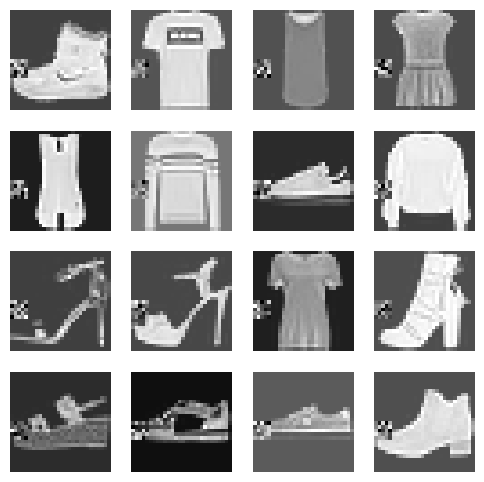

In [57]:
show_images(xbt, imsize=1.5)

In [58]:
xbt.min(), xbt.max()

(tensor(-3.25), tensor(2.69))

In [61]:
# export
def _rand_erase1(x, pct, xm, xs, mn, mx):
    szx = int(pct*xbt.shape[-2])
    szy = int(pct*xbt.shape[-1])
    stx = int(random.random()*(1-pct)*xbt.shape[-2])
    sty = int(random.random()*(1-pct)*xbt.shape[-1])
    init.normal_(xbt[:, :, stx:stx+szx, sty:sty+szy], mean=xm, std=xs)
    x.clamp_(mn, mx)

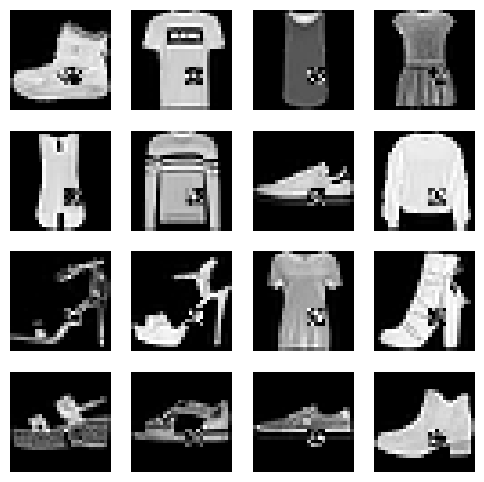

In [62]:
xb, _ = next(iter(dls.train))
xbt = xb[:16]
_rand_erase1(xbt, 0.2, xbt.mean(), xbt.std(), xbt.min(), xbt.max())
show_images(xbt, imsize=1.5)

In [63]:
xbt.mean(), xbt.std(), xbt.min(), xbt.max()

(tensor(-0.04), tensor(1.02), tensor(-0.80), tensor(2.06))

In [65]:
#export
def rand_erase(x, pct=0.2, max_num=4):
    xm, xs, mn, mx = x.mean(), x.std(), x.min(), x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
    return x

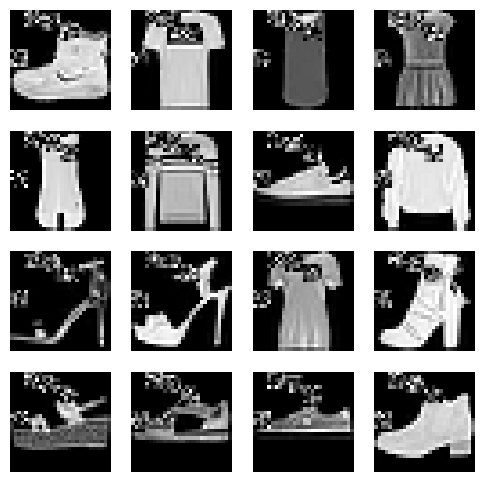

In [66]:
xb, _ = next(iter(dls.train))
xbt = xb[:16]
rand_erase(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [67]:
# export
class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct, self.max_num = pct, max_num
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)

In [68]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                   transforms.RandomHorizontalFlip(),
                   RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

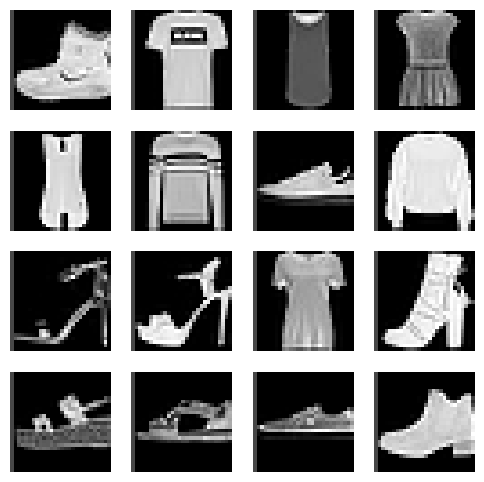

In [71]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
try:
    learn.fit(1)
except:
    pass
xb, yb = learn.batch
show_images(xb[:16], imsize=1.5)

accuracy,loss,epoch,train
0.743,0.905,0,True
0.703,1.468,0,False
0.797,0.636,1,True
0.852,0.430,1,False
0.857,0.412,2,True
0.856,0.420,2,False
0.889,0.320,3,True
0.895,0.299,3,False
0.904,0.274,4,True
0.905,0.274,4,False


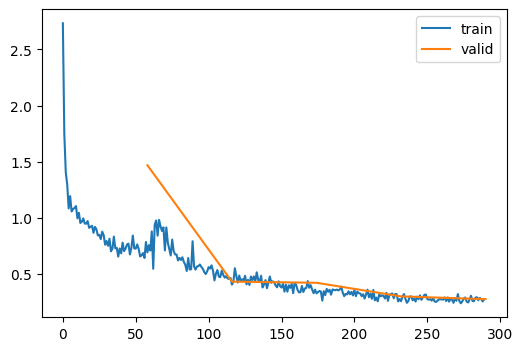

In [75]:
epochs = 5
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

# Random copy

In [76]:
xb, _ = next(iter(dls.train))
xbt = xb[:16]

In [77]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx1 = int(random.random()*(1-pct)*xbt.shape[-2])
sty1 = int(random.random()*(1-pct)*xbt.shape[-1])
stx2 = int(random.random()*(1-pct)*xbt.shape[-2])
sty2 = int(random.random()*(1-pct)*xbt.shape[-1])
stx1, sty1, stx2, sty2, szx, szy

(13, 1, 18, 11, 5, 5)

In [78]:
xbt[:,:,stx1:stx1+szx, sty1:sty1+szy] = xbt[:,:,stx2:stx2+szx,sty2:sty2+szy]

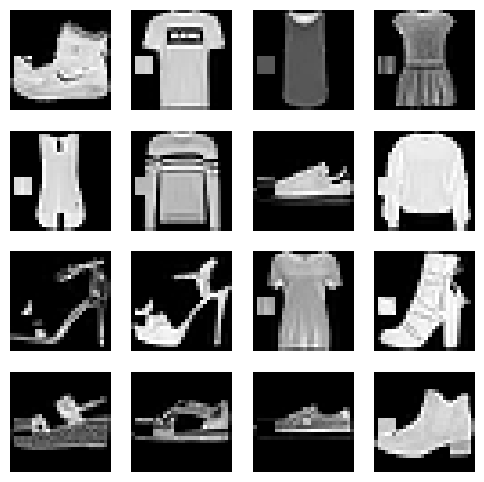

In [79]:
show_images(xbt, imsize=1.5)

In [80]:
#export
def _rand_copy1(x, pct):
    szx = int(pct*xbt.shape[-2])
    szy = int(pct*xbt.shape[-1])
    stx1 = int(random.random()*(1-pct)*xbt.shape[-2])
    sty1 = int(random.random()*(1-pct)*xbt.shape[-1])
    stx2 = int(random.random()*(1-pct)*xbt.shape[-2])
    sty2 = int(random.random()*(1-pct)*xbt.shape[-1])
    x[:,:,stx1:stx1+szx, sty1:sty1+szy] = x[:,:,stx2:stx2+szx,sty2:sty2+szy]

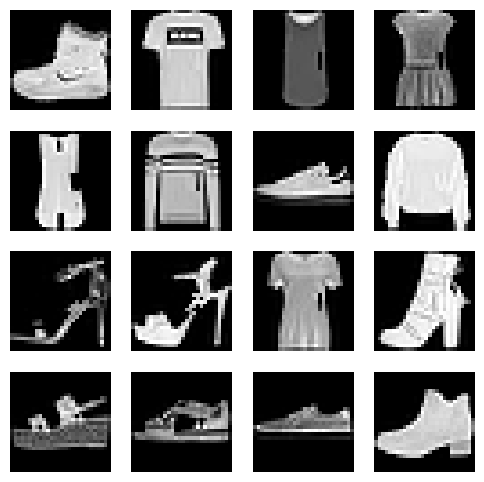

In [81]:
xb, _ = next(iter(dls.train))
xbt = xb[:16]
_rand_copy1(xbt, 0.2)
show_images(xbt, imsize=1.5)

In [82]:
# export
def random_copy(x, pct=0.2, max_num=4):
    num = random.randint(0, max_num)
    for i in range(num): _rand_copy1(x, pct)
    return x

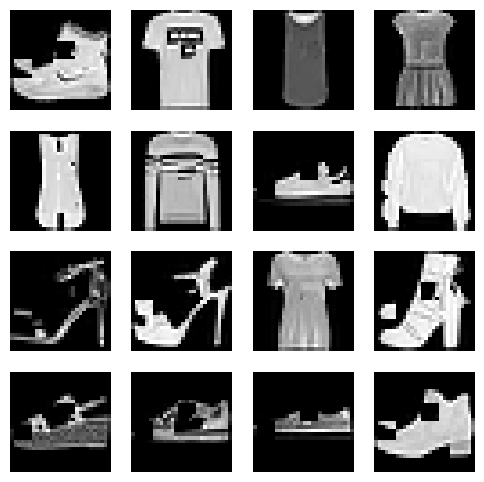

In [84]:
xb, _ = next(iter(dls.train))
xbt = xb[:16]
random_copy(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [85]:
# export
class RandCopy(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct, self.max_num = pct, max_num
    def forward(self, x): return random_copy(x, self.pct, self.max_num)

In [87]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                    transforms.RandomHorizontalFlip(),
                    RandCopy())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

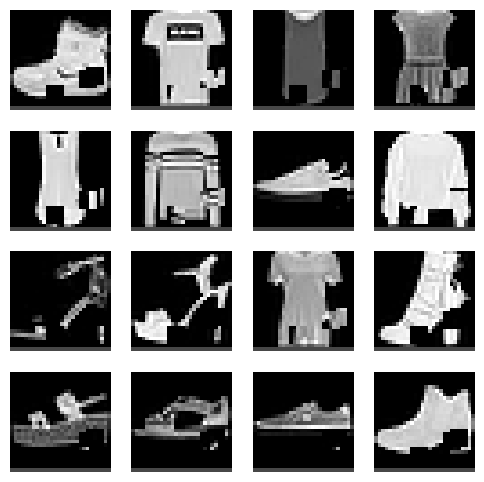

In [90]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
try: learn.fit(1)
except: pass
xb, yb = learn.batch
show_images(xb[:16], imsize=1.5)

accuracy,loss,epoch,train
0.701,1.050,0,True
0.752,0.834,0,False
0.792,0.678,1,True
0.827,0.506,1,False
0.834,0.503,2,True
0.838,0.452,2,False
0.862,0.409,3,True
0.877,0.348,3,False
0.881,0.354,4,True
0.891,0.320,4,False


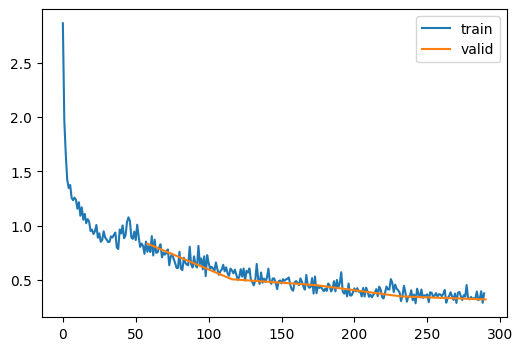

In [92]:
set_seed(1)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train
0.710,1.000,0,True
0.792,0.664,0,False
0.771,0.740,1,True
0.779,0.757,1,False
0.831,0.513,2,True
0.848,0.416,2,False
0.864,0.405,3,True
0.886,0.334,3,False
0.881,0.359,4,True
0.893,0.311,4,False


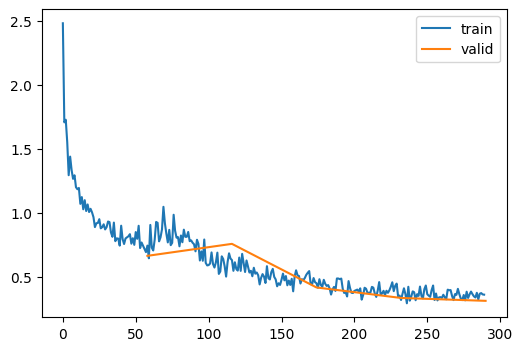

In [93]:
model2 = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn2 = TrainLearner(model2, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn2.fit(epochs)

In [94]:
mdl_path = Path('models')
torch.save(learn.model, mdl_path/'randcopy1.pkl')
torch.save(learn2.model, mdl_path/'randcopy2.pkl')

RuntimeError: Parent directory models does not exist.

accuracy,loss,epoch,train
0.891,0.320,0,False


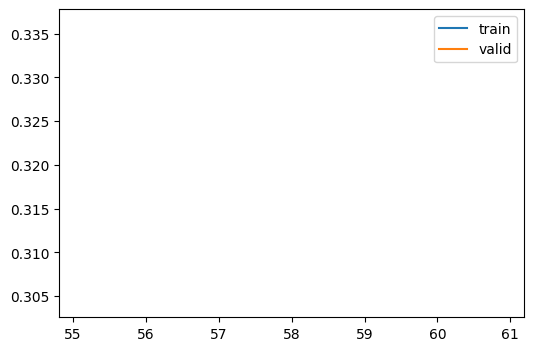

In [96]:
cp1 = CapturePredsCB()
learn.fit(1, train=False, cbs=cp1)

accuracy,loss,epoch,train
0.893,0.311,0,False


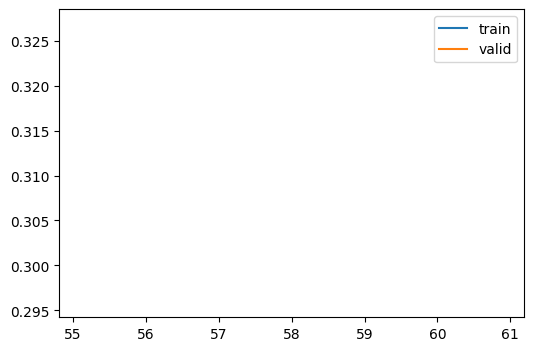

In [97]:
cp2 = CapturePredsCB()
learn2.fit(1, train=False, cbs=cp2)

In [98]:
ap1 = torch.cat(cp1.all_preds)
ap2 = torch.cat(cp2.all_preds)
at = torch.cat(cp1.all_targs)
ap1.shape, ap2.shape

(torch.Size([9216, 10]), torch.Size([9216, 10]))

In [99]:
ap = torch.stack([ap1, ap2]).mean(0).argmax(1)

In [100]:
round((ap==at).float().mean().item(), 3)

0.897